# Sentiment Analysis with Multinomal Naive Bayes Algorithm

1. [Loading and Preparing The Dataset](#1)
1. [Data Visualization](#2)
1. [Data Preprocessing](#3)
1. [Train Test Split](#4)
1. [Count Vectorizer](#5)
1. [TFIDF Vecktorizer](#6)
1. [Train Model - Multinomial Naive Bayes Algorithm](#7)
1. [Prediction to model](#8)

    

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/duygu-analizi/pos.txt
/kaggle/input/duygu-analizi/neg_reviews.txt


<a id="1"></a> <br>

# Loading and Preparing The Dataset


In [2]:
# Data Set Consisting of Negative Data
neg = pd.read_csv("/kaggle/input/duygu-analizi/neg_reviews.txt",delimiter = "\t")
neg = neg.sample(frac=1).reset_index(drop=True)
neg["label"] = "neg"

neg.rename(columns = {"beklentimin altında bir ürün kaliteli değil":"text"},inplace=True)
neg.head()

,text,label
0,ürün fena değil. sinekliği yapıştırmak için al...,neg
1,ürün gerçekten çok ses çıkartıyor rahatsız edi...,neg
2,-araba çok ağır,neg
3,arkadaslar kesinlikle kalici falan değil esime...,neg
4,arkadaşlar ürün bir def kullanılmak üzere üret...,neg


In [3]:
neg.shape 

(14878, 2)

In [4]:
#Data Set Consisting of Positive Data
pos = pd.read_csv("/kaggle/input/duygu-analizi/pos.txt",delimiter = "\t")
pos = pos.sample(frac=1).reset_index(drop=True)
pos["label"] = "pos"
pos.rename(columns={"fena değil paraya göre iyi.":"text"},inplace=True)
pos.head()

,text,label
0,1 seneden fazladır kullanıyorum. bence tavada ...,pos
1,urun guzel buyuk ekranli radyosu net cekiyo bu...,pos
2,bu fi̇yata güzel bi̇r ürün tavsi̇ye ederi̇m.ya...,pos
3,hoş bir ürün.lekeleri çıkarmada başarılı. özel...,pos
4,sonuç olarak bence fiyat-kalite oranı yüksek b...,pos


In [5]:
pos.shape

(219743, 2)

In [6]:
df = pd.concat([pos[:neg.shape[0]],neg],ignore_index=True)
df.head()

,text,label
0,1 seneden fazladır kullanıyorum. bence tavada ...,pos
1,urun guzel buyuk ekranli radyosu net cekiyo bu...,pos
2,bu fi̇yata güzel bi̇r ürün tavsi̇ye ederi̇m.ya...,pos
3,hoş bir ürün.lekeleri çıkarmada başarılı. özel...,pos
4,sonuç olarak bence fiyat-kalite oranı yüksek b...,pos


In [7]:
df.shape

(29756, 2)

In [8]:
print(f"{df.info()}")
print(f"\n NULL DEĞER \n{df.isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29756 entries, 0 to 29755
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    29756 non-null  object
 1   label   29756 non-null  object
dtypes: object(2)
memory usage: 465.1+ KB
None

 NULL DEĞER 
text     0
label    0
dtype: int64


<a id="2"></a> <br>

# Data Visualization


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


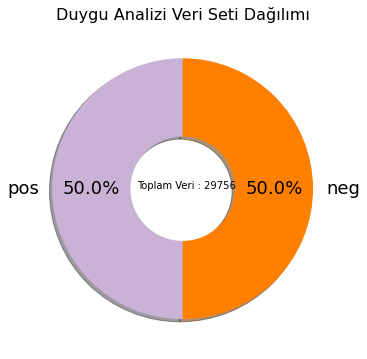

In [10]:
plt.figure(figsize = (6,6))
value_count_DF = df["label"].value_counts()
plt.pie(value_count_DF, labels = value_count_DF.index , startangle = 90,counterclock =False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 18}, shadow = True,
       colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Toplam Veri : {}'.format(df.shape[0]))
plt.title('Duygu Analizi Veri Seti Dağılımı', fontsize = 16);

<a id="3"></a> <br>

# Data Preprocessing


In [11]:
import string 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [12]:
#CLEANING SPECIAL CHARACTERS
def ozel_karakter (text):
    punctation = string.punctuation
    return text.translate(str.maketrans("","",punctation))

#CLEANING THE STOP WORDS FROM THE DATA SET
def stop_words_temizle (text):
    words = set(stopwords.words("turkish"))
    return (' '.join([i for i in text if i not in words and not i.isnumeric()]))


df["ozel_karakter"] = df["text"].apply(lambda x: ozel_karakter(x))
df["ozel_karakter"] = df["ozel_karakter"].str.split()
df["stop_word"] = df["ozel_karakter"].apply(lambda x : stop_words_temizle(x))

In [13]:
# VERİ SETİ İÇERİSİNDE İHTİYACIMIZ OLMAYAN SÜTUNLARI SİLİYORUZ
df.drop(["ozel_karakter","text"],inplace=True,axis=1)


In [14]:
df.head()

,label,stop_word
0,pos,seneden fazladır kullanıyorum bence tavada iyi...
1,pos,urun guzel buyuk ekranli radyosu net cekiyo pa...
2,pos,fi̇yata güzel bi̇r ürün tavsi̇ye ederi̇myanliz...
3,pos,hoş bir ürünlekeleri çıkarmada başarılı özelli...
4,pos,sonuç olarak bence fiyatkalite oranı yüksek bi...


<a id="4"></a> <br>

# Train Test Split

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(df["stop_word"].values.astype('U'),
                                                 df["label"].values.astype('U'),
                                                 test_size=0.2,
                                                 random_state=42)


<a id="5"></a> <br>

## Count Vectorizer

In [16]:
# COUNT VECTORİZE İLE SAYMA VEKTÖRLERİ OLUŞTURMA
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
print(X_train_counts.shape)

(23804, 66866)


<a id="6"></a> <br>

## TFIDF Vecktorizer

In [17]:
# TFİIDF VEKTÖRÜ OLUŞTURMA SAYMA VEKTÖRLERİNİ TFIDF VEKTÖRLERİNE DÖNÜŞTÜRÜCEZ

from sklearn.feature_extraction.text import TfidfTransformer
tfidf =TfidfTransformer() 
X_train_tfidf= tfidf.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(23804, 66866)


<a id="7"></a> <br>

# Train Model - Multinomial Naive Bayes Algorithm

In [18]:
# ÇOK MODLU NAIVE BAYES SINIFLANDIRICI EĞİTİYORUZ

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
clf = mnb.fit(X_train_tfidf, Y_train)

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_counts)


<a id="8"></a> <br>

## Prediction to model

In [19]:
#Measuring Model Performance

y_pred = clf.predict(X_test_tfidf)

for text, sentiment in zip(X_test[:5],y_pred[:]):
    print("\n %r => %s" %(text,sentiment ))


 'kitap biraz değil basit olmuş biraz açmalıydı konuları verdiği bilgiler güzel akılda kalıcı olmuyor maalesef kısa tutmuş işte' => neg

 'buradaki yorumlara bakarak aldım ürünü yazıklar olsunfırçayı düşük ayarda saniye yüzüme sürdüm gün batma hissi devam ettisanki yüz fırçası değil ayak törpüsü asla tavsiye etmem' => neg

 'artıları şık kaliteli tasarım ekran kasa oranı full hd gün ışığında bile rahat kullanılan ekran g cat7 desteği hızlı download upload hızı demek usb typec önde flaş olması 32gb rom 3gb ram saf android takılma kasma yok android one platformunda olduğu yıl güncelleme garantisi ilk telefonun alacak olmasıfiyat performans oranı makul bir işlemci snapdragon güncel oyunlarda bile kasmayan grafik işlemcisi' => pos

 'ürün telefonla birebir uyumlu kalitesi fiyata göre iyi' => pos

 'kurulumu kolay değil elinizde yaralar bile oluşabilirhızlı gonderi oluyorspor aleti ciddi kalori yaktriyorgürültülü olduğu kesin100 kg üstünde çatır çatır seslerde geliyoralırken bunları düşünü

In [20]:
# Test Result

from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,y_pred))

0.8363575268817204
